In [182]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
%matplotlib inline

In [183]:
df=pd.read_csv("50_Startups.csv")

In [184]:
df.head()

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


In [185]:
# renaming the column names
df.columns=["RDS", "Admin", "Marketing", "State", "Profit"]

In [186]:
df.head()

,RDS,Admin,Marketing,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


In [187]:
df.corr()

,RDS,Admin,Marketing,Profit
RDS,1.000000,0.241955,0.724248,0.972900
Admin,0.241955,1.000000,-0.032154,0.200717
Marketing,0.724248,-0.032154,1.000000,0.747766
Profit,0.972900,0.200717,0.747766,1.000000


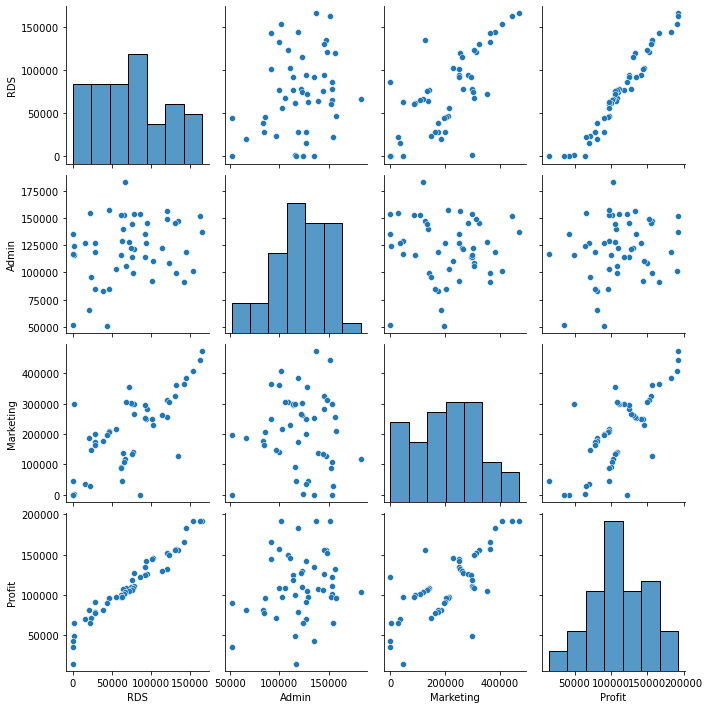

In [188]:
sns.pairplot(df)

In [189]:
# Finding the null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   RDS        50 non-null     float64
 1   Admin      50 non-null     float64
 2   Marketing  50 non-null     float64
 3   State      50 non-null     object 
 4   Profit     50 non-null     float64
dtypes: float64(4), object(1)
memory usage: 2.1+ KB


In [190]:
#finding duplicate values
df[df.duplicated()]

,RDS,Admin,Marketing,State,Profit


In [191]:
model=smf.ols("Profit~RDS+Admin+Marketing", data=df).fit()

In [192]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Profit   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     296.0
Date:                Thu, 30 Sep 2021   Prob (F-statistic):           4.53e-30
Time:                        14:32:32   Log-Likelihood:                -525.39
No. Observations:                  50   AIC:                             1059.
Df Residuals:                      46   BIC:                             1066.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   5.012e+04   6572.353      7.626      0.000    3.69e+04    6.34e+04
RDS            0.8057      0.045     17.846      0.000       0.715       0.897
Admin         -0.0268      0.051     -0.526      0.602      -0.130       0.076
Marketing      0.0272      0.016      1.655      0.105      -0.006       0.060
==============================================================================
Omnibus:                       14.838   Durbin-Watson:                   1.282
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               21.442
Skew:                          -0.949   Prob(JB):                     2.21e-05
Kurtosis:                       5.586   Cond. No.                     1.40e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.4e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Checking multi-colinearity using VIF index
## Calculate VIF = 1/(1-Rsquare) for all independent variables

In [193]:
rsqured_RDS= smf.ols("RDS~Admin+Marketing", data=df).fit().rsquared
VIF_RDS= 1/(1-(rsqured_RDS))
#print(f"VIF index for RDS is {VIF_RDS}")

rsqured_Admin= smf.ols("Admin~RDS+Marketing", data=df).fit().rsquared
VIF_Admin= 1/(1-(rsqured_Admin))
#print(f"VIF index for Admin is {VIF_Admin}")

rsqured_Marketing= smf.ols("Marketing~ Admin+RDS", data=df).fit().rsquared
VIF_Marketing= 1/(1-(rsqured_Marketing))
#print(f"VIF index for Marketing is {VIF_Marketing}")

vif=({"Featues":["RDS","Admin", "Marketing"], "VIF_Score":[VIF_RDS, VIF_Admin, VIF_Marketing]})
VIF= pd.DataFrame(vif)
VIF

,Featues,VIF_Score
0,RDS,2.468903
1,Admin,1.175091
2,Marketing,2.326773


In [194]:
# As all values are less than 3, there is no issue with multi-colinearity, 
# Hence we can consider all features for regression

# Checkng for residuals

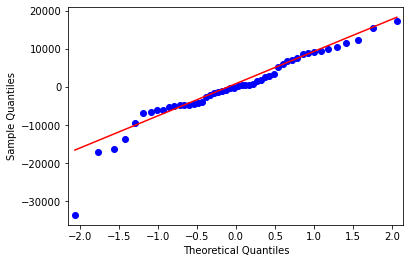

In [195]:
sm.qqplot(model.resid, line="q")
plt.show()

In [196]:
list(np.where(model.resid<-30000))

[array([49], dtype=int64)]

# Checking for outliers and influencers

In [197]:
# Coocks distance for outliers
c, standard_dist=model.get_influence().cooks_distance
c.shape

(50,)

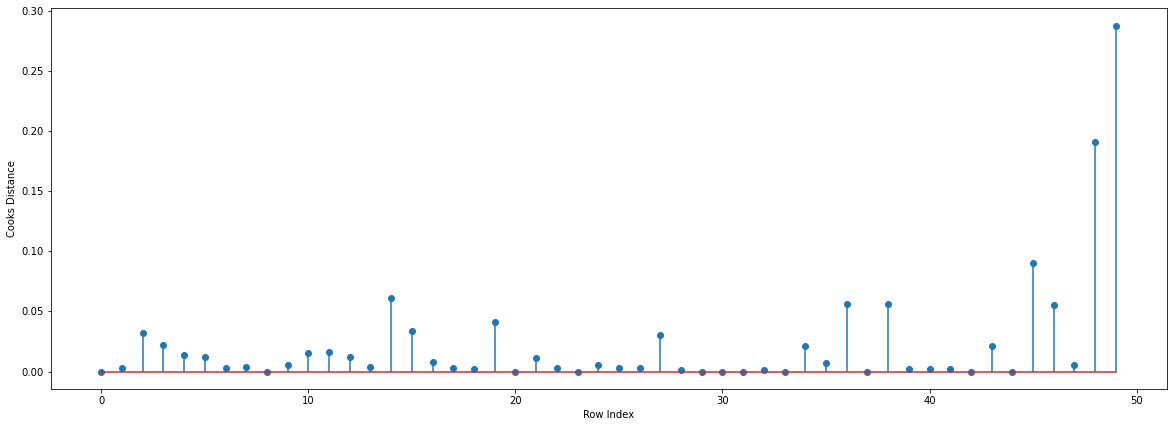

In [200]:
fig=plt.figure(figsize=(20,7))
plt.stem(np.arange(len(df)),np.round(c,3))
plt.xlabel('Row Index')
plt.ylabel('Cooks Distance')
plt.show()

In [201]:
# Index and value of influencer where C>0.5
np.argmax(cooks_distance) , np.max(cooks_distance)

(49, 0.28808229275432634)

In [202]:
from statsmodels.graphics.regressionplots import influence_plot

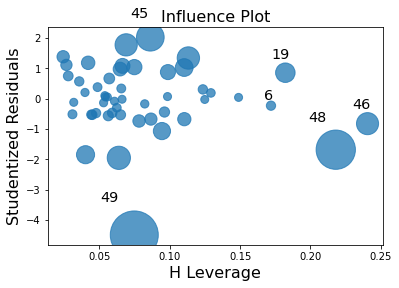

In [203]:
influence_plot(model)
plt.show()

In [204]:
# Leverage Cuttoff Value = 3*(k+1)/n ; k = no.of features/columns & n = no. of datapoints
k=df.shape[1]
n=df.shape[0]
leverage_cutoff = (3*(k+1))/n
leverage_cutoff

0.36

# Predicting values

In [205]:
model.predict(df)

0     192521.252890
1     189156.768232
2     182147.279096
3     173696.700026
4     172139.514183
5     163580.780571
6     158114.096669
7     160021.363048
8     151741.699699
9     154884.684110
10    135509.016367
11    135573.712961
12    129138.054182
13    127487.991663
14    149548.646335
15    146235.159985
16    116915.405401
17    130192.447208
18    129014.226806
19    115635.216367
20    116639.669231
21    117319.451640
22    114706.981717
23    109996.615221
24    113362.966113
25    102237.725065
26    110600.575350
27    114408.071457
28    101660.026005
29    101794.983452
30     99452.372936
31     97687.856276
32     99001.328985
33     97915.007805
34     89039.273741
35     90511.599568
36     75286.174585
37     89619.537708
38     69697.430648
39     83729.011977
40     74815.953991
41     74802.556239
42     70620.411821
43     60167.039963
44     64611.354916
45     47650.649687
46     56166.206853
47     46490.588983
48     49171.388158
49     48215.134111


In [211]:
df1=pd.DataFrame({"Predicted_values":np.round(model.predict(df),2), "Error":df.Profit-np.round(model.predict(df),2)})
df2=pd.concat([df, df1], axis =1)

In [212]:
df2

,RDS,Admin,Marketing,State,Profit,Predicted_values,Error
0,165349.20,136897.80,471784.10,New York,192261.83,192521.25,-259.42
1,162597.70,151377.59,443898.53,California,191792.06,189156.77,2635.29
2,153441.51,101145.55,407934.54,Florida,191050.39,182147.28,8903.11
3,144372.41,118671.85,383199.62,New York,182901.99,173696.70,9205.29
4,142107.34,91391.77,366168.42,Florida,166187.94,172139.51,-5951.57
5,131876.90,99814.71,362861.36,New York,156991.12,163580.78,-6589.66
6,134615.46,147198.87,127716.82,California,156122.51,158114.10,-1991.59
7,130298.13,145530.06,323876.68,Florida,155752.60,160021.36,-4268.76
8,120542.52,148718.95,311613.29,New York,152211.77,151741.70,470.07
9,123334.88,108679.17,304981.62,California,149759.96,154884.68,-5124.72
